<a href="https://colab.research.google.com/github/Zewtta/pme425_deeplearning_energyoptimization/blob/main/Manipula%C3%A7%C3%A3o_de_dados_est%C3%A1ticos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-348263091.py:90: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
/tmp/ipython-input-348263091.py:94: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


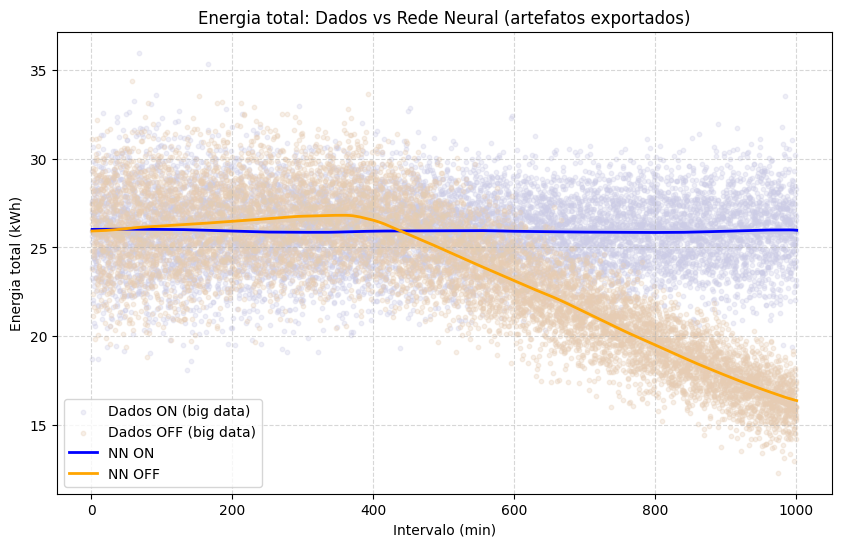

/tmp/ipython-input-348263091.py:111: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
/tmp/ipython-input-348263091.py:115: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


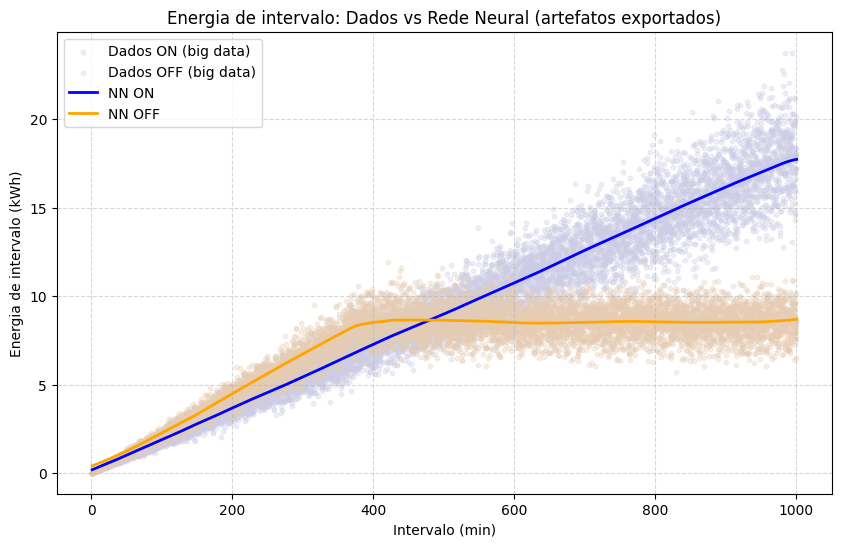

In [ ]:
import os, json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === helpers ===
def carregar_artefatos(base_dir):
    base = Path(base_dir)

    # modelo (pipeline completo)
    pipe = joblib.load(base / "model.joblib")

    # metadata (para pegar ordem das colunas etc.)
    meta_path = base / "metadata.json"
    if meta_path.exists():
        with open(meta_path, "r", encoding="utf-8") as f:
            meta = json.load(f)
        feature_cols = meta.get("feature_cols", ["Intervalo", "state"])
        target_cols  = meta.get("target_cols",  ["E_total_kWh", "energia_intervalo"])
    else:
        feature_cols = ["Intervalo", "state"]
        target_cols  = ["E_total_kWh", "energia_intervalo"]

    # dataset (parquet preferível; cai pro csv se não tiver)
    if (base / "dataset_aug.parquet").exists():
        df = pd.read_parquet(base / "dataset_aug.parquet")
    else:
        df = pd.read_csv(base / "dataset_aug.csv")

    return pipe, df, feature_cols, target_cols

def prever_consumo_duplo(pipe, t_min, feature_cols):
    """
    Gera previsão ON (state=0) e OFF (state=1) para um único tempo (em minutos).
    O treino original usou 'Intervalo' em SEGUNDOS, então converto t_min*60.
    """
    t_sec = float(t_min) * 60.0
    # monta DataFrames respeitando a ordem de feature_cols
    linha_on  = {col: 0.0 for col in feature_cols}
    linha_off = {col: 0.0 for col in feature_cols}

    if "Intervalo" not in feature_cols or "state" not in feature_cols:
        raise ValueError(f"As features esperadas ('Intervalo' e 'state') não batem com {feature_cols}")

    linha_on["Intervalo"]  = t_sec
    linha_on["state"]      = 0.0  # ON
    linha_off["Intervalo"] = t_sec
    linha_off["state"]     = 1.0  # OFF

    X_on  = pd.DataFrame([linha_on ], columns=feature_cols).values
    X_off = pd.DataFrame([linha_off], columns=feature_cols).values

    y_on  = pipe.predict(X_on )[0]  # [E_total_kWh, energia_intervalo]
    y_off = pipe.predict(X_off)[0]
    return y_on, y_off

# === função principal (lendo dos arquivos) ===
def plotar_resultado_treinamento_from_exports(base_dir, step=5):
    """
    Lê modelo e dataset exportados e plota:
      - Dispersão dos dados (ON/OFF)
      - Curvas previstas pela NN (ON/OFF)
    step em minutos (resolução da grade)
    """
    pipe, df, feature_cols, target_cols = carregar_artefatos(base_dir)

    # garante a coluna de minutos (dataset usa Intervalo em segundos)
    df = df.copy()
    df["Intervalo_min"] = df["Intervalo"] / 60.0

    # grade de tempo (min)
    t_min = df["Intervalo_min"].min()
    t_max = df["Intervalo_min"].max()
    t_grid = np.arange(t_min, t_max + step, step)

    # previsões
    E_on_total, E_off_total = [], []
    E_on_int,   E_off_int   = [], []

    for t in t_grid:
        y_on, y_off = prever_consumo_duplo(pipe, t, feature_cols)
        E_on_total.append(y_on[0]);  E_off_total.append(y_off[0])
        E_on_int.append(y_on[1]);    E_off_int.append(y_off[1])

    # ===============================
    # Gráfico 1: Energia total
    # ===============================
    plt.figure(figsize=(10,6))
    plt.scatter(
        df[df["state"]==0]["Intervalo_min"], df[df["state"]==0][target_cols[0]],
        s=10, alpha=0.3, c=(0.8, 0.8, 0.9, 0.05), label="Dados ON (big data)"
    )
    plt.scatter(
        df[df["state"]==1]["Intervalo_min"], df[df["state"]==1][target_cols[0]],
        s=10, alpha=0.3, c=(0.9, 0.8, 0.7, 0.05), label="Dados OFF (big data)"
    )
    plt.plot(t_grid, E_on_total,  c="blue",   lw=2, label="NN ON")
    plt.plot(t_grid, E_off_total, c="orange", lw=2, label="NN OFF")
    plt.xlabel("Intervalo (min)")
    plt.ylabel("Energia total (kWh)")
    plt.title("Energia total: Dados vs Rede Neural (artefatos exportados)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # ===============================
    # Gráfico 2: Energia de intervalo
    # ===============================
    plt.figure(figsize=(10,6))
    plt.scatter(
        df[df["state"]==0]["Intervalo_min"], df[df["state"]==0][target_cols[1]],
        s=10, alpha=0.3, c=(0.8, 0.8, 0.9, 0.05), label="Dados ON (big data)"
    )
    plt.scatter(
        df[df["state"]==1]["Intervalo_min"], df[df["state"]==1][target_cols[1]],
        s=10, alpha=0.3, c=(0.9, 0.8, 0.7, 0.05), label="Dados OFF (big data)"
    )
    plt.plot(t_grid, E_on_int,  c="blue",   lw=2, label="NN ON")
    plt.plot(t_grid, E_off_int, c="orange", lw=2, label="NN OFF")
    plt.xlabel("Intervalo (min)")
    plt.ylabel("Energia de intervalo (kWh)")
    plt.title("Energia de intervalo: Dados vs Rede Neural (artefatos exportados)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# === uso ===
BASE_DIR = "/content/drive/MyDrive/Mestrado FEI/Aulas/PME 425 - Manufatura Digital e Sistemas Cyber-Fisicos/Artigo Final/Simulações Plant Simulator/Resultados treinamento DNN + Data augmentation"
plotar_resultado_treinamento_from_exports(BASE_DIR, step=5)


In [ ]:
import json, joblib
import numpy as np
from pathlib import Path

# ====== CONFIG ======
BASE_DIR = "/content/drive/MyDrive/Mestrado FEI/Aulas/PME 425 - Manufatura Digital e Sistemas Cyber-Fisicos/Artigo Final/Simulações Plant Simulator/Resultados treinamento DNN + Data augmentation"
# Se vc salvou em "Resultados treinamento DNN + Data augmentation", troque o caminho acima.

# Unidade do "Intervalo" usada no TREINO do modelo:
INTERVAL_UNIT = "seconds"   # "seconds" (padrão do seu treino) ou "minutes"

# ====== CARREGAR MODELO + METADADOS ======
base = Path(BASE_DIR)
pipe = joblib.load(base / "model.joblib")

try:
    meta = json.loads((base / "metadata.json").read_text(encoding="utf-8"))
    feature_cols = meta.get("feature_cols", ["Intervalo","state"])
    target_cols  = meta.get("target_cols",  ["E_total_kWh","energia_intervalo"])
except FileNotFoundError:
    feature_cols = ["Intervalo","state"]
    target_cols  = ["E_total_kWh","energia_intervalo"]

# ====== HELPERS ======
def _row_for(t_min, state, unit="seconds"):
    """Monta a linha de features respeitando a ordem de feature_cols."""
    t_val = float(t_min) * 60.0 if unit == "seconds" else float(t_min)
    vals = {"Intervalo": t_val, "state": float(state)}
    return np.array([[vals[c] for c in feature_cols]], dtype=float)

# ===============================
# Previsão ON/OFF (usando artefatos exportados)
# ===============================
def prever_consumo_duplo(pipe, intervalo_min, unit=INTERVAL_UNIT):
    X_on  = _row_for(intervalo_min, 0, unit)  # ON
    X_off = _row_for(intervalo_min, 1, unit)  # OFF
    y_on  = pipe.predict(X_on ).reshape(-1)   # [E_total, E_intervalo]
    y_off = pipe.predict(X_off).reshape(-1)
    return y_on, y_off

# ===============================
# Encontrar Δt* para total e intervalo (usando só o modelo exportado)
# ===============================
def achar_pontos_otimos_duplos(pipe, t_min=1, t_max=1000, step=1, unit=INTERVAL_UNIT):
    """
    Retorna TODOS os Δt* (pontos de cruzamento) para energia total e energia de intervalo.
    """
    t_grid = np.arange(t_min, t_max + step, step)
    E_on_all, E_off_all = [], []

    for t in t_grid:
        y_on, y_off = prever_consumo_duplo(pipe, t, unit)
        E_on_all.append(y_on)
        E_off_all.append(y_off)

    E_on_all = np.array(E_on_all)
    E_off_all = np.array(E_off_all)

    resultados = {}
    for j, nome in enumerate(["E_total", "E_intervalo"]):
        diff = E_on_all[:, j] - E_off_all[:, j]
        idx = np.where(np.sign(diff[:-1]) * np.sign(diff[1:]) < 0)[0]

        pontos = []
        for i in idx:
            t0, t1 = t_grid[i], t_grid[i+1]
            d0, d1 = diff[i], diff[i+1]
            t_star = t0 - d0*(t1-t0)/(d1-d0)  # interpolação linear
            pontos.append(t_star)

        resultados[nome] = pontos if pontos else None

    return resultados

# ===============================
# Execução (idêntica à sua, mas usando o pipe carregado)
# ===============================
intervalo_min = 200  # ajuste aqui se quiser
y_on, y_off = prever_consumo_duplo(pipe, intervalo_min)

if y_on[0] < y_off[0]:
    print("DEIXAR LIGADA ✅ - Melhor opção de chaveamento para o intervalo")
else:
    print("DEIXAR DESLIGADA 🔴 - Melhor opção de chaveamento para o intervalo")

print("-"*100)
print(f"\nConsumo previsto para {intervalo_min} min de intervalo e 24h de processo:")
print(f"  ON  = {y_on[0]:.3f} kWh (total), {y_on[1]:.3f} kWh (intervalo)")
print(f"  OFF = {y_off[0]:.3f} kWh (total), {y_off[1]:.3f} kWh (intervalo)")

# Range padrão 1..1000 min; se preferir, substitua por limites do dataset exportado.
resultados = achar_pontos_otimos_duplos(pipe, t_min=1, t_max=1000, step=1)

print("\nPontos ótimos previstos:")
if resultados["E_total"]:
    print("  Δt* total      = " + ", ".join([f"{v:.2f} min" for v in resultados["E_total"]]))
else:
    print("  Δt* total      = Nenhum cruzamento encontrado")

if resultados["E_intervalo"]:
    print("  Δt* intervalo  = " + ", ".join([f"{v:.2f} min" for v in resultados["E_intervalo"]]))
else:
    print("  Δt* intervalo  = Nenhum cruzamento encontrado")

print("-"*100)
media_t = (max(resultados["E_total"]) + max(resultados["E_intervalo"])) / 2
print(f"Média dos maiores Δt*: {media_t:.2f} min")


DEIXAR LIGADA ✅ - Melhor opção de chaveamento para o intervalo
----------------------------------------------------------------------------------------------------

Consumo previsto para 200 min de intervalo e 24h de processo:
  ON  = 25.923 kWh (total), 3.674 kWh (intervalo)
  OFF = 26.472 kWh (total), 4.483 kWh (intervalo)

Pontos ótimos previstos:
  Δt* total      = 42.05 min, 438.86 min
  Δt* intervalo  = 479.92 min
----------------------------------------------------------------------------------------------------
Média dos maiores Δt*: 459.39 min


/tmp/ipython-input-3476572574.py:110: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[df["state"]==0]["Intervalo_min"], df[df["state"]==0][yname],
/tmp/ipython-input-3476572574.py:112: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[df["state"]==1]["Intervalo_min"], df[df["state"]==1][yname],


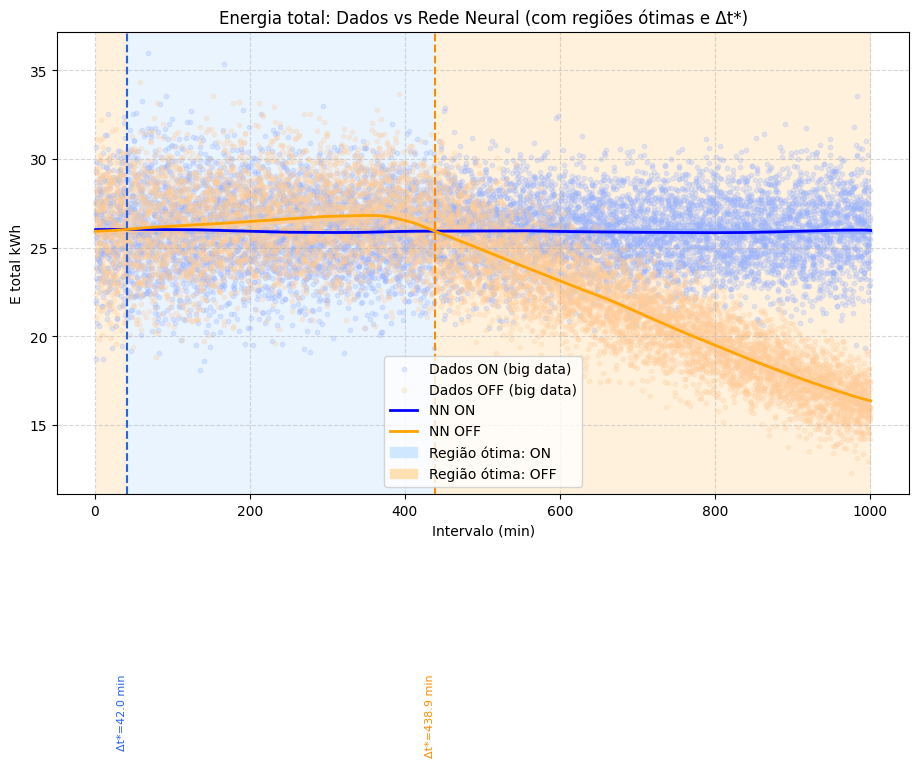

/tmp/ipython-input-3476572574.py:110: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[df["state"]==0]["Intervalo_min"], df[df["state"]==0][yname],
/tmp/ipython-input-3476572574.py:112: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[df["state"]==1]["Intervalo_min"], df[df["state"]==1][yname],


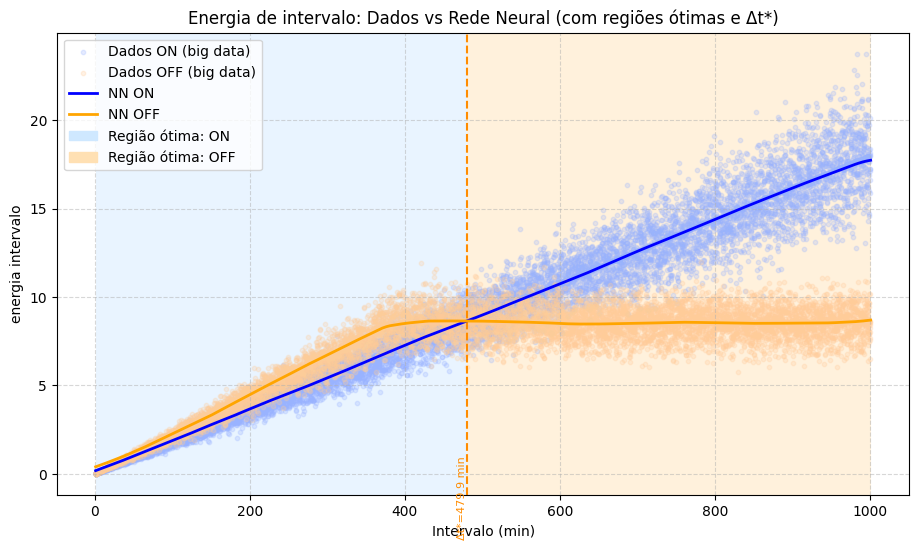

In [ ]:
import json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

# ========= CONFIG =========
BASE_DIR = "/content/drive/MyDrive/Mestrado FEI/Aulas/PME 425 - Manufatura Digital e Sistemas Cyber-Fisicos/Artigo Final/Simulações Plant Simulator/Resultados treinamento DNN + Data augmentation"
INTERVAL_UNIT = "seconds"  # "seconds" (treino com Intervalo em s) ou "minutes"
STEP_MIN = 5               # resolução da grade (minutos)

# cores (pode trocar se quiser)
COLORS = {
    "ON":  {"line": "blue",   "fill": "#cfe8ff", "bar": "#2463eb"},  # azul clarinho
    "OFF": {"line": "orange", "fill": "#ffe0b3", "bar": "#ff8c00"}   # laranja clarinho
}

# ========= LOAD =========
base = Path(BASE_DIR)
pipe = joblib.load(base / "model.joblib")

try:
    meta = json.loads((base / "metadata.json").read_text(encoding="utf-8"))
    feature_cols = meta.get("feature_cols", ["Intervalo","state"])
    target_cols  = meta.get("target_cols",  ["E_total_kWh","energia_intervalo"])
except FileNotFoundError:
    feature_cols = ["Intervalo","state"]
    target_cols  = ["E_total_kWh","energia_intervalo"]

# dataset só p/ pegar o range real de Intervalo
if (base / "dataset_aug.parquet").exists():
    df = pd.read_parquet(base / "dataset_aug.parquet")
else:
    df = pd.read_csv(base / "dataset_aug.csv")

df = df.copy()
df["Intervalo_min"] = df["Intervalo"] / 60.0

t_min = float(df["Intervalo_min"].min())
t_max = float(df["Intervalo_min"].max())
t_grid = np.arange(t_min, t_max + STEP_MIN, STEP_MIN)

# ========= HELPERS =========
def _row_for(t_min_val, state, unit="seconds"):
    t_val = float(t_min_val) * 60.0 if unit == "seconds" else float(t_min_val)
    vals = {"Intervalo": t_val, "state": float(state)}
    return np.array([[vals[c] for c in feature_cols]], dtype=float)

def prever_consumo_duplo(pipe, t_min_val, unit=INTERVAL_UNIT):
    X_on  = _row_for(t_min_val, 0, unit)  # ON
    X_off = _row_for(t_min_val, 1, unit)  # OFF
    y_on  = pipe.predict(X_on ).reshape(-1)   # [E_total, E_intervalo]
    y_off = pipe.predict(X_off).reshape(-1)
    return y_on, y_off

def curvas(pipe, t_grid, unit=INTERVAL_UNIT):
    """Retorna arrays (E_on_total, E_off_total, E_on_int, E_off_int) alinhados a t_grid."""
    E_on_total, E_off_total, E_on_int, E_off_int = [], [], [], []
    for t in t_grid:
        y_on, y_off = prever_consumo_duplo(pipe, t, unit)
        E_on_total.append(y_on[0]);  E_off_total.append(y_off[0])
        E_on_int.append(y_on[1]);    E_off_int.append(y_off[1])
    return (np.array(E_on_total), np.array(E_off_total),
            np.array(E_on_int),   np.array(E_off_int))

def intersecoes_e_regioes(pipe, t_grid, y_on, y_off, unit=INTERVAL_UNIT, idx_target=0):
    """
    Calcula Δt* (interseções por interpolação linear) e retorna regiões [ini, fim, winner],
    onde winner ∈ {"ON","OFF"} é o regime com MENOR energia no meio do intervalo.
    """
    diff = y_on - y_off
    idx = np.where(np.sign(diff[:-1]) * np.sign(diff[1:]) < 0)[0]

    tstars = []
    for i in idx:
        t0, t1 = t_grid[i], t_grid[i+1]
        d0, d1 = diff[i], diff[i+1]
        # interpolação linear do zero
        t_star = t0 - d0 * (t1 - t0) / (d1 - d0)
        tstars.append(t_star)

    bounds = [t_grid[0]] + tstars + [t_grid[-1]]
    regioes = []
    for a, b in zip(bounds[:-1], bounds[1:]):
        mid = 0.5*(a + b)
        yon, yoff = prever_consumo_duplo(pipe, mid, unit)
        yon_v  = yon[idx_target]
        yoff_v = yoff[idx_target]
        winner = "ON" if yon_v < yoff_v else "OFF"
        regioes.append((a, b, winner))
    return tstars, regioes

def plot_uma_figura(ax, titulo, yname, df, t_grid, y_on, y_off, tstars, regioes):
    # fundo por regiões
    for a, b, win in regioes:
        ax.axvspan(a, b, color=COLORS[win]["fill"], alpha=0.45, linewidth=0)

    # barras verticais nas interseções (cor do regime que vence à direita)
    for k, t in enumerate(tstars):
        # acha qual região começa à direita desta barra
        for a, b, win in regioes:
            if a <= t < b or np.isclose(t, a):
                ax.axvline(t, color=COLORS[win]["bar"], linestyle="--", linewidth=1.5)
                ax.text(t, ax.get_ylim()[1], f"Δt*={t:.1f} min", rotation=90,
                        va="top", ha="right", fontsize=8, color=COLORS[win]["bar"])
                break

    # dispersão (dados reais)
    ax.scatter(df[df["state"]==0]["Intervalo_min"], df[df["state"]==0][yname],
               s=10, alpha=0.25, c=(0.6,0.7,1.0,0.15), label="Dados ON (big data)")
    ax.scatter(df[df["state"]==1]["Intervalo_min"], df[df["state"]==1][yname],
               s=10, alpha=0.25, c=(1.0,0.8,0.6,0.15), label="Dados OFF (big data)")

    # curvas previstas
    ax.plot(t_grid, y_on,  color=COLORS["ON"]["line"],  lw=2, label="NN ON")
    ax.plot(t_grid, y_off, color=COLORS["OFF"]["line"], lw=2, label="NN OFF")

    ax.set_xlabel("Intervalo (min)")
    ax.set_ylabel(yname.replace("_", " "))
    ax.set_title(titulo)
    ax.grid(True, linestyle="--", alpha=0.5)

    # legendas incluindo faixas de região ótima
    patch_on  = mpatches.Patch(color=COLORS["ON"]["fill"],  label="Região ótima: ON")
    patch_off = mpatches.Patch(color=COLORS["OFF"]["fill"], label="Região ótima: OFF")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles + [patch_on, patch_off], labels + ["Região ótima: ON", "Região ótima: OFF"])

# ========= CURVAS =========
Eon_tot, Eoff_tot, Eon_int, Eoff_int = curvas(pipe, t_grid, INTERVAL_UNIT)

# ========= FIGURA 1: Energia total =========
tstars_tot, regioes_tot = intersecoes_e_regioes(pipe, t_grid, Eon_tot, Eoff_tot,
                                                unit=INTERVAL_UNIT, idx_target=0)
fig1, ax1 = plt.subplots(figsize=(11,6))
plot_uma_figura(
    ax1,
    "Energia total: Dados vs Rede Neural (com regiões ótimas e Δt*)",
    target_cols[0],
    df, t_grid, Eon_tot, Eoff_tot, tstars_tot, regioes_tot
)
plt.show()

# ========= FIGURA 2: Energia de intervalo =========
tstars_int, regioes_int = intersecoes_e_regioes(pipe, t_grid, Eon_int, Eoff_int,
                                                unit=INTERVAL_UNIT, idx_target=1)
fig2, ax2 = plt.subplots(figsize=(11,6))
plot_uma_figura(
    ax2,
    "Energia de intervalo: Dados vs Rede Neural (com regiões ótimas e Δt*)",
    target_cols[1],
    df, t_grid, Eon_int, Eoff_int, tstars_int, regioes_int
)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/fig1_total_energia_zoom_pt.png'

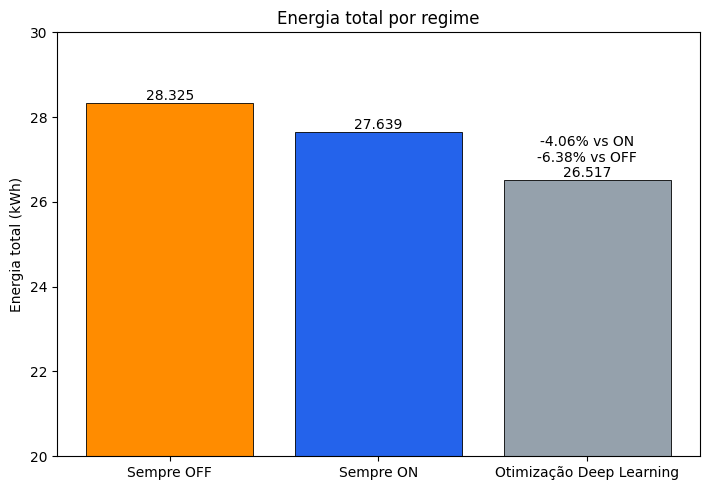

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Dados (da sua tabela) ----------
df = pd.DataFrame({
    "Regime": ["Sempre OFF", "Sempre ON", "Otimização Deep Learning"],
    "Total_kWh": [28.325, 27.639, 26.5174],
    "Working_kWh": [12.0276, 12.0024, 12.0],
    "Setting_up_kWh": [16.295, 0.0, 8.575],
    "Standby_kWh": [0.0, 15.6342, 5.94],
})

# Paleta (conforme padrão que combinamos)
LARANJA = "#ff8c00"   # Sempre OFF
AZUL    = "#2463eb"   # Sempre ON
CINZA   = "#95A1AC"   # Otimização DL

cores_regime = [LARANJA, AZUL, CINZA]

# ---------- Figura 1: Energia total (zoom 20–30 kWh) ----------
plt.figure(figsize=(7.2,5))
bars = plt.bar(df["Regime"], df["Total_kWh"], color=cores_regime, edgecolor="black", linewidth=0.6)

for p in bars:
    plt.annotate(f"{p.get_height():.3f}",
                 (p.get_x()+p.get_width()/2, p.get_height()),
                 ha="center", va="bottom", fontsize=10)

plt.ylim(20, 30)
plt.ylabel("Energia total (kWh)")
plt.title("Energia total por regime")
plt.xticks(rotation=0)

# Anotar economias da Otimização DL vs baselines
nn = df.loc[df["Regime"]=="Otimização Deep Learning","Total_kWh"].values[0]
on = df.loc[df["Regime"]=="Sempre ON","Total_kWh"].values[0]
off = df.loc[df["Regime"]=="Sempre OFF","Total_kWh"].values[0]

pct_vs_on  = (on - nn) / on * 100.0
pct_vs_off = (off - nn) / off * 100.0

idx_nn = df.index[df["Regime"]=="Otimização Deep Learning"][0]
plt.text(idx_nn, nn + 0.35, f"-{pct_vs_on:.2f}% vs ON\n-{pct_vs_off:.2f}% vs OFF",
         ha="center", va="bottom", fontsize=10)

plt.tight_layout()
fig1_path = "/mnt/data/fig1_total_energia_zoom_pt.png"
plt.savefig(fig1_path, dpi=200)
plt.show()

# ---------- Figura 2: Barras agrupadas por estado (kWh absolutos) ----------
plt.figure(figsize=(8.2,5.2))
estados = ["Working_kWh", "Setting_up_kWh", "Standby_kWh"]
x = np.arange(len(estados))
w = 0.25

vals_off = df.loc[df["Regime"]=="Sempre OFF", estados].values.flatten()
vals_on  = df.loc[df["Regime"]=="Sempre ON", estados].values.flatten()
vals_nn  = df.loc[df["Regime"]=="Otimização Deep Learning", estados].values.flatten()

plt.bar(x - w, vals_off, width=w, color=LARANJA, edgecolor="black", linewidth=0.6, label="Sempre OFF")
plt.bar(x,       vals_on,  width=w, color=AZUL,    edgecolor="black", linewidth=0.6, label="Sempre ON")
plt.bar(x + w,   vals_nn,  width=w, color=CINZA,   edgecolor="black", linewidth=0.6, label="Otimização DL")

plt.xticks(x, ["Working", "Setting-up", "Standby"])
plt.ylabel("kWh por 1.000 peças")
plt.title("Consumo absoluto por estado e regime")
plt.legend()
plt.tight_layout()
fig2_path = "/mnt/data/fig2_estados_barras_agrupadas_pt.png"
plt.savefig(fig2_path, dpi=200)
plt.show()

# ---------- Figura 3: Contribuição por estado para Δ(kWh) da Otimização DL vs Sempre ON ----------
comp = pd.Series({
    "Working":    df.loc[df["Regime"]=="Otimização Deep Learning","Working_kWh"].values[0]    - df.loc[df["Regime"]=="Sempre ON","Working_kWh"].values[0],
    "Setting-up": df.loc[df["Regime"]=="Otimização Deep Learning","Setting_up_kWh"].values[0] - df.loc[df["Regime"]=="Sempre ON","Setting_up_kWh"].values[0],
    "Standby":    df.loc[df["Regime"]=="Otimização Deep Learning","Standby_kWh"].values[0]    - df.loc[df["Regime"]=="Sempre ON","Standby_kWh"].values[0],
})

plt.figure(figsize=(8,5))
colors = [AZUL if v<0 else LARANJA for v in comp.values]  # redução (azul), aumento (laranja)
plt.barh(comp.index, comp.values, color=colors, edgecolor="black", linewidth=0.6)
plt.axvline(0, color="black", linewidth=1)
for i,(k,v) in enumerate(comp.items()):
    plt.text(v + (0.25 if v>0 else -0.25), i, f"{v:+.3f} kWh", va="center",
             ha="left" if v>0 else "right", fontsize=10)
plt.title("Contribuição por estado para Δ(kWh) da Otimização DL vs Sempre ON\n(negativo = redução de consumo)")
plt.xlabel("Variação em kWh por 1.000 peças")
plt.tight_layout()
fig3_path = "/mnt/data/fig3_delta_contribuicoes_vs_on_pt.png"
plt.savefig(fig3_path, dpi=200)
plt.show()

# ---------- Figura 4: Economia percentual da Otimização DL vs baselines ----------
ref = df[df["Regime"]!="Otimização Deep Learning"].copy()
ref["Economia_%_vs_DL"] = (ref["Total_kWh"] - nn)/ref["Total_kWh"] * 100

plt.figure(figsize=(6.4,4.6))
plt.bar(ref["Regime"], ref["Economia_%_vs_DL"], color=[LARANJA, AZUL], edgecolor="black", linewidth=0.6)
for i,v in enumerate(ref["Economia_%_vs_DL"]):
    plt.text(i, v+0.15, f"{v:.2f}%", ha="center", va="bottom", fontsize=10)
plt.ylabel("Economia da Otimização DL (%)")
plt.title("Economia percentual da Otimização DL vs baselines")
plt.xticks(rotation=0)
plt.tight_layout()
fig4_path = "/mnt/data/fig4_economia_percentual_vs_baselines_pt.png"
plt.savefig(fig4_path, dpi=200)
plt.show()

fig1_path, fig2_path, fig3_path, fig4_path
